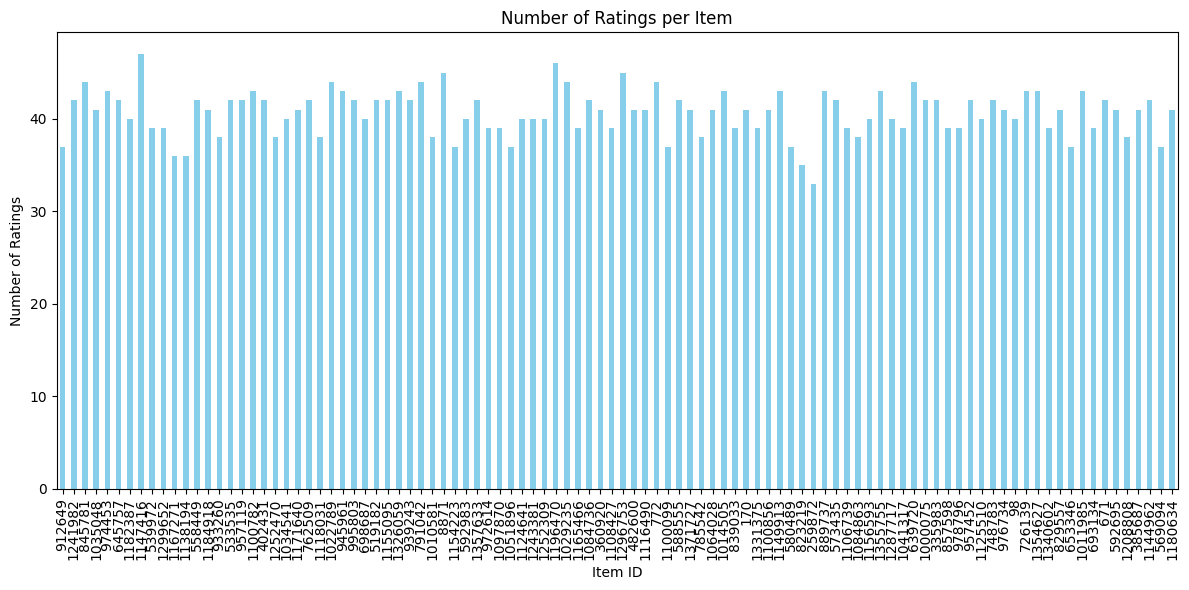

Dataset prepared successfully.
Active Users: {'U1': None, 'U2': None, 'U3': None}
Target Items: {'I1': None, 'I2': 8871}
Thresholds: {'U1': None, 'U2': None, 'U3': None}


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#API key
api_key = '6cded85307abb9c31e7482024ed285f6'

# Function to fetch popular movies
def fetch_popular_movies(api_key, total_pages=5):

    all_movies = []
    for page in range(1, total_pages + 1):
        url = f'https://api.themoviedb.org/3/movie/popular?api_key={api_key}&language=en-US&page={page}'
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            all_movies.extend(data['results'])
        else:
            print(f"Error: Unable to fetch data, status code {response.status_code}")
            break

    return all_movies

# Simulate user ratings
def simulate_ratings(movies, num_users=50, missing_percentage=0.2):

    movie_ids = [movie['id'] for movie in movies]
    user_ids = [f"U{i+1}" for i in range(num_users)]

    # Create a user-item matrix with random ratings (1 to 5), converted to float
    ratings = np.random.randint(1, 6, size=(num_users, len(movie_ids))).astype(float)

    # Introduce missing ratings
    mask = np.random.rand(num_users, len(movie_ids)) < missing_percentage
    ratings[mask] = np.nan

    # Convert to DataFrame
    user_item_matrix = pd.DataFrame(ratings, columns=movie_ids, index=user_ids)
    return user_item_matrix

# Pick active users and target items
def pick_active_users_and_items(user_item_matrix):

    # Count missing ratings per user
    missing_counts = user_item_matrix.isna().sum(axis=1)

    # Select users with specific missing ratings
    active_users = {
        'U1': missing_counts[missing_counts == 2].index[0] if (missing_counts == 2).any() else None,
        'U2': missing_counts[missing_counts == 3].index[0] if (missing_counts == 3).any() else None,
        'U3': missing_counts[missing_counts == 5].index[0] if (missing_counts == 5).any() else None,
    }

    # Count missing ratings percentage per item
    missing_percentage_per_item = user_item_matrix.isna().mean(axis=0) * 100

    # Select items with specific missing ratings percentages
    target_items = {
        'I1': missing_percentage_per_item[missing_percentage_per_item.between(3.5, 4.5)].index[0] if (missing_percentage_per_item.between(3.5, 4.5)).any() else None,
        'I2': missing_percentage_per_item[missing_percentage_per_item.between(9.5, 10.5)].index[0] if (missing_percentage_per_item.between(9.5, 10.5)).any() else None,
    }

    return active_users, target_items

# Plot ratings for each item
def plot_ratings_distribution(user_item_matrix):
    """
    Plot the number of ratings for each item.
    :param user_item_matrix: DataFrame, user-item rating matrix
    """
    ratings_count = user_item_matrix.notna().sum(axis=0)
    plt.figure(figsize=(12, 6))
    ratings_count.plot(kind='bar', color='skyblue')
    plt.title('Number of Ratings per Item')
    plt.xlabel('Item ID')
    plt.ylabel('Number of Ratings')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Calculate threshold 
def calculate_threshold(user_item_matrix, active_users):
    """
    Calculate the maximum number of users who have co-rated at least 30% of items with each active user.
    :param user_item_matrix: DataFrame, user-item rating matrix
    :param active_users: dict, active users
    :return: dict, thresholds for each active user
    """
    thresholds = {}
    num_items = user_item_matrix.shape[1]

    for user_key, user_id in active_users.items():
        if user_id is None:
            thresholds[user_key] = None
            continue

        user_ratings = user_item_matrix.loc[user_id]
        co_rated_counts = user_item_matrix.apply(lambda x: (~x.isna() & ~user_ratings.isna()).sum(), axis=1)
        thresholds[user_key] = co_rated_counts[co_rated_counts >= 0.3 * num_items].max()

    return thresholds

def main():
    movies = fetch_popular_movies(api_key, total_pages=5)
    user_item_matrix = simulate_ratings(movies, num_users=50, missing_percentage=0.2)
    active_users, target_items = pick_active_users_and_items(user_item_matrix)
    plot_ratings_distribution(user_item_matrix)
    thresholds = calculate_threshold(user_item_matrix, active_users)
    user_item_matrix.to_csv("user_item_matrix.csv", index=True)

    print("Dataset prepared successfully.")
    print(f"Active Users: {active_users}")
    print(f"Target Items: {target_items}")
    print(f"Thresholds: {thresholds}")

if __name__ == "__main__":
    main()

In [ ]:
# Part 1
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def compute_similarity(user_item_matrix, method="cosine", bias_adjust=False):
    matrix = user_item_matrix.copy()

    if bias_adjust:
        matrix = matrix.sub(matrix.mean(axis=1), axis=0)

    similarity_matrix = pd.DataFrame(index=matrix.index, columns=matrix.index)

    for user1 in matrix.index:
        for user2 in matrix.index:
            if user1 == user2:
                similarity_matrix.loc[user1, user2] = 1.0
            else:
                common_ratings = matrix.loc[[user1, user2]].dropna(axis=1, how='any')

                if method == "cosine":
                    sim = cosine_similarity(common_ratings)[0, 1] if not common_ratings.empty else 0
                elif method == "pearson":
                    sim, _ = pearsonr(common_ratings.loc[user1], common_ratings.loc[user2]) if not common_ratings.empty else (0, 0)
                else:
                    raise ValueError("Invalid method. Choose 'cosine' or 'pearson'.")

                similarity_matrix.loc[user1, user2] = sim

    return similarity_matrix.astype(float)

def predict_ratings(user_item_matrix, similarity_matrix, active_users, use_discount=False):
    predictions = {}

    for user_key, user_id in active_users.items():
        if user_id is None:
            continue

        for item in user_item_matrix.columns:
            if np.isnan(user_item_matrix.loc[user_id, item]):
                similarities = similarity_matrix[user_id].drop(user_id).dropna()
                top_users = similarities.nlargest(int(len(similarities) * 0.2))

                if use_discount:
                    discount_factor = 1 / (1 + top_users.apply(lambda x: abs(x)))
                    discounted_similarities = top_users * discount_factor
                else:
                    discounted_similarities = top_users

                weighted_ratings = user_item_matrix.loc[discounted_similarities.index, item].dropna() * discounted_similarities.loc[user_item_matrix.loc[discounted_similarities.index, item].dropna().index]

                if not discounted_similarities.empty and weighted_ratings.sum() != 0:
                    predictions[(user_id, item)] = weighted_ratings.sum() / discounted_similarities.sum()

    return predictions

def pick_active_users_and_items(user_item_matrix):
    active_users = {f"user_{i}": user for i, user in enumerate(user_item_matrix.index)}
    active_items = {f"item_{i}": item for i, item in enumerate(user_item_matrix.columns)}
    return active_users, active_items

def plot_comparison(predictions_dict):
    labels = list(predictions_dict.keys())
    values = [len(predictions) for predictions in predictions_dict.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
    plt.xlabel('Prediction Methods')
    plt.ylabel('Number of Predictions')
    plt.title('Comparison of Predictions Across Methods')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main_part_1():
    user_item_matrix = pd.read_csv("user_item_matrix.csv", index_col=0)
    active_users, _ = pick_active_users_and_items(user_item_matrix)
    cosine_sim = compute_similarity(user_item_matrix, method="cosine", bias_adjust=False)
    predictions_cosine = predict_ratings(user_item_matrix, cosine_sim, active_users)
    cosine_sim_bias = compute_similarity(user_item_matrix, method="cosine", bias_adjust=True)
    predictions_cosine_bias = predict_ratings(user_item_matrix, cosine_sim_bias, active_users)
    pcc_sim = compute_similarity(user_item_matrix, method="pearson")
    predictions_pcc = predict_ratings(user_item_matrix, pcc_sim, active_users)
    predictions_cosine_ds = predict_ratings(user_item_matrix, cosine_sim, active_users, use_discount=True)
    predictions_cosine_bias_ds = predict_ratings(user_item_matrix, cosine_sim_bias, active_users, use_discount=True)
    predictions_pcc_ds = predict_ratings(user_item_matrix, pcc_sim, active_users, use_discount=True)

    print("Predictions without Discount:")
    print("Cosine:", predictions_cosine)
    print("Cosine with Bias:", predictions_cosine_bias)
    print("PCC:", predictions_pcc)

    print("\nPredictions with Discount:")
    print("Cosine:", predictions_cosine_ds)
    print("Cosine with Bias:", predictions_cosine_bias_ds)
    print("PCC:", predictions_pcc_ds)



if __name__ == "__main__":
    main_part_1()


Predictions without Discount:
Cosine: {('U1', '974453'): 2.7860886727911356, ('U1', '558449'): 2.2164685275498184, ('U1', '1100782'): 2.338237952513769, ('U1', '945961.1'): 2.778509659295882, ('U1', '995803'): 3.220196610295808, ('U1', '1154223'): 2.5586312878684607, ('U1', '1357633'): 2.558952024780131, ('U1', '1196470'): 2.559330834608599, ('U1', '335983'): 2.6783563095970417, ('U1', '1138194'): 2.2365039682775163, ('U1', '580489'): 2.7769755242186682, ('U1', '639720'): 2.561383871129931, ('U1', '976734'): 2.107306938004645, ('U1', '1243381'): 1.768044110806891, ('U1', '259872'): 1.22678485174245, ('U1', '1125510'): 2.7828388976869993, ('U1', '1358820'): 2.5589028065901624, ('U2', '1299652'): 2.105398957327371, ('U2', '957119'): 2.5537156807631387, ('U2', '533535'): 1.4485114077320995, ('U2', '1034541'): 3.3466592865315516, ('U2', '1124641'): 2.104535960701018, ('U2', '1010581'): 2.673765418364252, ('U2', '1331375'): 3.214944500695722, ('U2', '1084736'): 3.459974933107382, ('U2', '12